# consumo_privado


In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from itertools import product
from sklearn.model_selection import GridSearchCV
import optuna
from optuna.samplers import TPESampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from functools import partial
import joblib
import warnings
import tensorflow as tf
import random

seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.get_logger().setLevel('ERROR')
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.set_visible_devices([], 'GPU')
warnings.filterwarnings("ignore")

cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, 'data')
input_path = os.path.join(data_path, 'input')
output_path = os.path.join(data_path, 'output')
target_var = 'consumo_privado'
t_samples = 4*4
keep_all = False

## Importación de datos

In [11]:
# función para obtener el trimestre al que pertenece el mes y la fecha
# del último mes del trimestre respectivo
def get_last_day_of_quarter(date):
    quarter = date.quarter
    year = date.year
    if quarter == 1:
        return pd.Timestamp(f'{year}-03-31')
    elif quarter == 2:
        return pd.Timestamp(f'{year}-06-30')
    elif quarter == 3:
        return pd.Timestamp(f'{year}-09-30')
    else:
        return pd.Timestamp(f'{year}-12-31')
# función para sumar si no hay ningún valor nulo o devolver nulo de lo contrario
def sum_or_nan(x):
    return np.nan if x.isna().any() else x.sum()
# función para promediar si no hay ningún valor nulo o devolver nulo de lo contrario
def mean_or_nan(x):
    return np.nan if x.isna().any() else x.mean()

In [12]:
# se lee la metadata
metadata_path = os.path.join(cwd_path,'metadatos.xlsx')
variables = pd.read_excel(metadata_path)
# se agrega el tipo de función de agregación dependiendo de la naturaleza
# de la variable
variables['agg_func'] = np.where(variables.subsector.isin(['tipo_de_cambio', 'tasa_lider', 'tasa_de_interes', 'indice_mensual_actividad_economica', 'inflacion_de_guatemala']),
                                 mean_or_nan, sum_or_nan)

# se toman las filas donde la componente tiene un 1
filtro_componente = (variables[target_var]
                     .fillna(0)
                     .astype(bool))
variables_componente = variables[filtro_componente].reset_index(drop=True)
# se dividen las variables en periodicidades trimestrales y no trimestrales
variables_componente_trimestrales = variables_componente[variables_componente.frecuencia.str.lower() == 'trimestral'].reset_index(drop=True)
variables_componente_no_trimestrales = variables_componente[variables_componente.frecuencia.str.lower() != 'trimestral'].reset_index(drop=True)

# se crea el diccionario para leer los archivos csv de las variables trimestrales
input_files_trimestrales = {}
for idx, row in variables_componente_trimestrales.iterrows():
  input_files_trimestrales[row.variable] = [row.sector, row.subsector, f'{row.variable}.csv']
# se leen las variables
input_list_trimestrales = []
for name, path in input_files_trimestrales.items():
  file_path = os.path.join(input_path, *path)
  df_input = (pd
                .read_csv(file_path, sep=',')
                .rename(columns={'Fecha': 'fa', 'Valor': name})
                .assign(fa = lambda df: pd.to_datetime(df['fa'], dayfirst=True))
                .set_index('fa')
                )
  input_list_trimestrales.append(df_input)
# se crea el dataframe
try:
  df_trimestrales = pd.concat(input_list_trimestrales, axis=1, join='outer')
except ValueError:
  df_trimestrales = pd.DataFrame()

# se crea el diccionario para leer los archivos csv de las variables no trimestrales
input_files_no_trimestrales = {}
for idx, row in variables_componente_no_trimestrales.iterrows():
  input_files_no_trimestrales[row.variable] = [row.sector, row.subsector, f'{row.variable}.csv']
# se leen las variables
input_list_no_trimestrales = []
for name, path in input_files_no_trimestrales.items():
  agg_vars = dict()
  agg_vars[name] = variables[variables.variable == name].agg_func.values[0]
  file_path = os.path.join(input_path, *path)
  df_input = (pd
                .read_csv(file_path, sep=',')
                .rename(columns={'Fecha': 'fa', 'Valor': name})
                .assign(fa = lambda df: pd.to_datetime(df['fa'], dayfirst=True))
                .set_index('fa')
                )
  df_input['fa'] = df_input.index
  df_input.fa = df_input.fa.apply(get_last_day_of_quarter)
  df_input.reset_index(drop=True, inplace=True)
  df_input = df_input.groupby('fa').agg(agg_vars)
  input_list_no_trimestrales.append(df_input)
# se crea el dataframe
try:
  df_no_trimestrales = pd.concat(input_list_no_trimestrales, axis=1, join='outer')
except ValueError:
  df_no_trimestrales = pd.DataFrame()

# se unen las variables trimestrales con las no trimestrales transformadas
df_list = []
if len(df_trimestrales) > 0:
  df_list.append(df_trimestrales)
if len(df_no_trimestrales) > 0:
  df_list.append(df_no_trimestrales)

df = pd.concat(df_list, axis=1, join='outer')
df.rename(columns={'gasto_consumo_final_hogar_isflsh': 'consumo_privado'}, inplace=True)
df.dropna(inplace=True)
output_filepath = os.path.join(output_path, 'datasets', f'{target_var}_dataset.xlsx')
df.to_excel(output_filepath)

In [13]:
df.head()

,consumo_privado,ipc_total,tasa_int_lider_pm,oper_estab_mon_me,oper_estab_mon_mn,egreso_div_cap_imp,egreso_div_servicios_trans,egreso_div_transf_donaciones,egreso_div_turismo_viajes,ingreso_div_exp,...,taxs,comunic,finan,inmob,act_profes,act_servicios,ensenanza,salud,otr_act,tipo_cambio_de_referencia_gtq_usd
fa,,,,,,,,,,,,,,,,,,,,,
2013-03-31,9430.14,4.126667,4.126667,12.38,61924.3,3382780.66,20026.55,18423.77,229962.61,1773389.92,...,98.493333,93.153333,102.370000,98.206667,93.420000,100.930000,112.383333,93.480000,94.913333,7.841923
2013-06-30,11800.43,4.396667,4.396667,13.19,62960.4,3519154.36,20557.10,25280.12,192368.52,1775236.16,...,98.383333,99.856667,98.396667,99.500000,99.180000,97.770000,97.476667,99.463333,99.520000,7.800233
2013-09-30,12004.06,4.456667,4.456667,13.37,68802.7,3453331.68,18580.50,23445.33,130908.76,1451833.16,...,99.126667,97.943333,99.003333,100.263333,97.870000,92.410000,103.570000,104.866667,104.113333,7.884067
2013-12-31,13766.49,4.390000,4.390000,13.17,67978.3,3439032.27,32281.93,29219.07,171191.35,1464416.88,...,103.996667,109.046667,100.226667,102.030000,109.530000,108.893333,86.576667,102.186667,101.446667,7.907965
2014-03-31,10326.90,3.630000,3.630000,10.89,81291.4,3364878.23,10652.51,18461.20,218526.42,1721894.64,...,101.263333,97.380000,107.486667,102.290000,100.146667,105.316667,113.450000,104.166667,99.783333,7.781481


## Procesamiento

In [14]:
def data_processing(df, target_var, t_samples, keep_all):
    df_shifted = df[[target_var]].copy()
    for n in range(1, t_samples + 1):
        for col in df.columns:
            df_shifted[f'{col}_t_{n}'] = df[col].shift(n)
    df_shifted = df_shifted.dropna()

    for col in df.columns:
        df_shifted[f'{col}_prom_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].mean(axis=1)
        df_shifted[f'{col}_desv_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].std(axis=1)
        df_shifted[f'{col}_min_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].min(axis=1)
        df_shifted[f'{col}_max_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].max(axis=1)
        df_shifted[f'{col}_sum_{t_samples}'] = df_shifted[[f'{col}_t_{i}' for i in range(1, t_samples + 1)]].sum(axis=1)

    if not keep_all:
        columns_to_keep = [target_var] + [f'{col}_t_{1}' for col in df.columns] + \
                          [f'{col}_{agg}_{t_samples}' for col in df.columns for agg in ['prom', 'desv', 'min', 'max', 'sum']]
        df_shifted = df_shifted[columns_to_keep]

    return df_shifted

df_shifted = data_processing(df, target_var, t_samples, keep_all)

X = df_shifted.drop(columns=[target_var])
y = df_shifted[target_var]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(
    X_train_scaled, 
    index=X_train.index,
    columns=X_train.columns
)

X_test_scaled = pd.DataFrame(
    X_test_scaled, 
    index=X_test.index, 
    columns=X_test.columns
)

pca_hv = PCA(n_components=0.99)
X_train_pca_hv = pca_hv.fit_transform(X_train_scaled)
X_test_pca_hv = pca_hv.transform(X_test_scaled)
print(f'{pca_hv.n_components_=}')

X_train_pca_hv = pd.DataFrame(
    X_train_pca_hv,
    index=X_train.index,
    columns=[f'PC{i+1}' for i in range(X_train_pca_hv.shape[1])]
)

X_test_pca_hv = pd.DataFrame(
    X_test_pca_hv,
    index=X_test.index,
    columns=[f'PC{i+1}' for i in range(X_test_pca_hv.shape[1])]
)

pca_lv = PCA(n_components=0.9)
X_train_pca_lv = pca_lv.fit_transform(X_train_scaled)
X_test_pca_lv = pca_lv.transform(X_test_scaled)
print(f'{pca_lv.n_components_=}')

X_train_pca_lv = pd.DataFrame(
    X_train_pca_lv,
    index=X_train.index,
    columns=[f'PC{i+1}' for i in range(X_train_pca_lv.shape[1])]
)

X_test_pca_lv = pd.DataFrame(
    X_test_pca_lv,
    index=X_test.index,
    columns=[f'PC{i+1}' for i in range(X_test_pca_lv.shape[1])]
)

pca_hv.n_components_=13
pca_lv.n_components_=3


## Entrenamiento

In [15]:
def optimize_arima(y_train, X_train, p_values, d_values, q_values):
    best_score, best_params, best_model = float("inf"), None, None
    
    for p, d, q in product(p_values, d_values, q_values):
        try:
            model = ARIMA(y_train, order=(p, d, q), exog=X_train).fit()
            if model.aic < best_score:
                best_score, best_params, best_model = model.aic, (p, d, q), model
        except Exception as e:
            continue

    return best_model, best_params

def arquitectura_ann(cant_capas, cant_neurons, learning_rate, dropout_rate, input_dim):
    model = Sequential([Input(shape=(input_dim,))])
    for _ in range(cant_capas):
        model.add(Dense(cant_neurons, activation='relu', kernel_initializer='he_normal', kernel_regularizer=l2(1e-3)))
        model.add(BatchNormalization())
        model.add(Dropout(rate=dropout_rate))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')
    return model

def optimizar_ann(trial, X_train, y_train):
    cant_capas = trial.suggest_int('cant_capas', 1, 4, 1)
    cant_neurons = trial.suggest_int('cant_neurons', 2, 8, 2)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    learning_rate = trial.suggest_categorical('learning_rate', [0.001, 0.01])
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.7)
    
    model = arquitectura_ann(cant_capas, cant_neurons, learning_rate, dropout_rate, X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    history = model.fit(
        X_train, y_train, 
        validation_split=0.2,
        epochs=20, batch_size=batch_size, verbose=0, callbacks=[early_stopping]
    )
    return min(history.history['val_loss'])

In [16]:
def train_models(X_train_pca_lv, X_train_pca_hv, y_train):
    seed_value = 42
    best_models = {}

    p_values = range(1, 6)
    model_ar, best_ar_params = optimize_arima(y_train.asfreq('QE'), X_train_pca_lv.asfreq('QE'), p_values, [0], [0])
    best_models['ar'] = model_ar
    print(f"AR Best Parameters: {best_ar_params}")

    p_values = range(1, 6)
    d_values = range(0, 3)
    q_values = range(1, 6)
    model_arima, best_arima_params = optimize_arima(y_train.asfreq('QE'), X_train_pca_lv.asfreq('QE'), p_values, d_values, q_values)
    best_models['arima'] = model_arima
    print(f"ARIMA Best Parameters: {best_arima_params}")

    params_ridge = {'alpha': np.logspace(-3, 3, 21),
        'random_state': [seed_value]}
    grid_ridge = GridSearchCV(Ridge(), params_ridge, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_ridge.fit(X_train_pca_lv, y_train)
    best_models['lr'] = grid_ridge.best_estimator_
    print(f"LR Ridge Best Parameters: {grid_ridge.best_params_}")
    
    params_knn = {
        'n_neighbors': [3, 5, 10, 20],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan', 'minkowski']
        }
    grid_knn = GridSearchCV(KNeighborsRegressor(),
                            params_knn, cv=3, scoring='neg_mean_squared_error',
                            n_jobs=-1, verbose=0)
    grid_knn.fit(X_train_pca_hv, y_train)
    best_models['knn'] = grid_knn.best_estimator_
    print(f"KNN Best Parameters: {grid_knn.best_params_}")

    params_rf = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [2, 4, 6],
        'min_samples_split': [2, 5, 7],
        'random_state': [seed_value]
    }
    grid_rf = GridSearchCV(RandomForestRegressor(),
                           params_rf, cv=3, scoring='neg_mean_squared_error',
                           n_jobs=-1, verbose=0)
    grid_rf.fit(X_train_pca_hv, y_train)
    best_models['rf'] = grid_rf.best_estimator_
    print(f"Random Forest Best Parameters: {grid_rf.best_params_}")

    params_xgb = {
        'n_estimators': [30, 50, 70, 90],
        'max_depth': [2, 3, 4],
        'min_samples_split': [2, 3, 4],
        'min_child_weight': [1, 5, 10],
        'gamma': [0, 0.1],
        'subsample': [0.6, 0.7],
        'colsample_bytree': [0.6, 0.7],
        'learning_rate': [0.001, 0.01, 0.05],
        'random_state': [seed_value]
    }
    grid_xgb = GridSearchCV(xgb.XGBRegressor(n_jobs=-1),
                            params_xgb,
                            cv=3, scoring='neg_mean_squared_error',
                            verbose=0)
    grid_xgb.fit(X_train_pca_hv, y_train)
    best_models['xgb'] = grid_xgb.best_estimator_
    print(f"XGBoost Best Parameters: {grid_xgb.best_params_}")

    study = optuna.create_study(direction='minimize', sampler=TPESampler(seed=42))
    study.optimize(
        partial(optimizar_ann, X_train=X_train_pca_hv, y_train=y_train),
        n_trials=30,
        n_jobs=-1,
        show_progress_bar=True)

    best_params = study.best_params
    print(f"ANN Best Parameters: {best_params}")

    model_ann = arquitectura_ann(best_params['cant_capas'], best_params['cant_neurons'], best_params['learning_rate'], best_params['dropout_rate'], X_train_pca_hv.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model_ann.fit(
        X_train_pca_hv, y_train, 
        validation_split=0.2,
        epochs=20, batch_size=best_params['batch_size'], verbose=0, callbacks=[early_stopping]
    )
    best_models['ann'] = model_ann

    return best_models

best_models = train_models(X_train_pca_lv, X_train_pca_hv, y_train)

AR Best Parameters: (5, 0, 0)
ARIMA Best Parameters: (5, 0, 1)
LR Ridge Best Parameters: {'alpha': 251.18864315095772, 'random_state': 42}
KNN Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


/Users/damoib/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/damoib/anaconda3/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/damoib/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/damoib/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/Users/damoib/anaconda3/lib/python3.11/site-p

Random Forest Best Parameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}


[I 2024-12-01 23:57:56,833] A new study created in memory with name: no-name-e6aa56ee-247b-485b-a377-e105a38285a0


XGBoost Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 4, 'min_child_weight': 1, 'min_samples_split': 2, 'n_estimators': 90, 'random_state': 42, 'subsample': 0.7}


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-12-01 23:58:05,804] Trial 10 finished with value: 483088704.0 and parameters: {'cant_capas': 2, 'cant_neurons': 6, 'batch_size': 32, 'learning_rate': 0.001, 'dropout_rate': 0.452090520295626}. Best is trial 10 with value: 483088704.0.
[I 2024-12-01 23:58:05,940] Trial 2 finished with value: 483121312.0 and parameters: {'cant_capas': 2, 'cant_neurons': 4, 'batch_size': 64, 'learning_rate': 0.001, 'dropout_rate': 0.44999493740372537}. Best is trial 10 with value: 483088704.0.
[I 2024-12-01 23:58:06,257] Trial 9 finished with value: 482821888.0 and parameters: {'cant_capas': 2, 'cant_neurons': 8, 'batch_size': 128, 'learning_rate': 0.01, 'dropout_rate': 0.610476549149435}. Best is trial 9 with value: 482821888.0.
[I 2024-12-01 23:58:08,774] Trial 4 finished with value: 483140160.0 and parameters: {'cant_capas': 1, 'cant_neurons': 2, 'batch_size': 128, 'learning_rate': 0.001, 'dropout_rate': 0.33990287180251255}. Best is trial 9 with value: 482821888.0.
[I 2024-12-01 23:58:08,880] 

## Evaluación

In [17]:
def evaluate(best_models, X_train_pca_lv, X_train_pca_hv, y_train, X_test_pca_lv, X_test_pca_hv, y_test, target_var):
    results = {}
    for name, model in best_models.items():
        # Predicción y cálculo del MSE en el conjunto de entrenamiento
        if name in ('ar', 'arima'):
            y_train_pred = model.predict(start=0, end=len(y_train)-1, exog=X_train_pca_lv)
        elif name == 'ann':
            y_train_pred = model.predict(X_train_pca_hv, verbose=0)
        elif name == 'lr':
            y_train_pred = model.predict(X_train_pca_lv)
        else:
            y_train_pred = model.predict(X_train_pca_hv)
        train_mse = mean_squared_error(y_train, y_train_pred)
        
        # Predicción y cálculo del MSE en el conjunto de prueba
        if name in ('ar', 'arima'):
            y_test_pred = model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test_pca_lv)
        elif name == 'ann':
            y_test_pred = model.predict(X_test_pca_hv, verbose=0)
        elif name == 'lr':
            y_test_pred = model.predict(X_test_pca_lv)
        else:
            y_test_pred = model.predict(X_test_pca_hv)
        test_mse = mean_squared_error(y_test, y_test_pred)

        train_rmse = np.sqrt(train_mse)
        test_rmse = np.sqrt(test_mse)
        
        # Almacenar los resultados
        results[name] = {
            'y_train_pred': y_train_pred,
            'train_rmse': train_rmse,
            'y_test_pred': y_test_pred,
            'test_rmse': test_rmse
        }
        
        print(f"{name}: train_rmse={train_rmse:,.2f}, test_rmse={test_rmse:,.2f}")

    best_model_name = min(results, key=lambda x: results[x]['test_rmse'])
    best_model = best_models[best_model_name]
    print(f"Mejor modelo: {best_model_name}")

    export_path = os.path.join(output_path, 'models')
    with open(os.path.join(export_path ,f"{target_var}.pkl"), "wb") as f:
        joblib.dump(best_model, f)
    print(f"Modelo {target_var} exportado exitosamente.")

    export_path = os.path.join(output_path, 'tables')
    df_results = pd.DataFrame(results).T[['train_rmse', 'test_rmse']].sort_values('test_rmse')
    df_results.to_excel(os.path.join(export_path ,f"{target_var}.xlsx"))
    print(f"Resultados {target_var} exportados exitosamente.")

    export_path = os.path.join(output_path, 'predictions')
    df_pred = pd.DataFrame(data=list(results[best_model_name]['y_test_pred']), index=y_test.index, columns=['y_pred'])
    df_pred.to_excel(os.path.join(export_path, f'y_test_{target_var}.xlsx'))
    print(f"Predicciones {target_var} exportadas exitosamente.")
    return results

results = evaluate(best_models, X_train_pca_lv, X_train_pca_hv, y_train, X_test_pca_lv, X_test_pca_hv, y_test, target_var)

ar: train_rmse=911.69, test_rmse=3,050.89
arima: train_rmse=754.53, test_rmse=3,603.81
lr: train_rmse=2,462.65, test_rmse=3,724.45
knn: train_rmse=2,139.87, test_rmse=1,563.97
rf: train_rmse=1,236.52, test_rmse=1,107.53
xgb: train_rmse=491.69, test_rmse=1,830.84
ann: train_rmse=17,562.44, test_rmse=22,418.85
Mejor modelo: rf
Modelo consumo_privado exportado exitosamente.
Resultados consumo_privado exportados exitosamente.
Predicciones consumo_privado exportadas exitosamente.


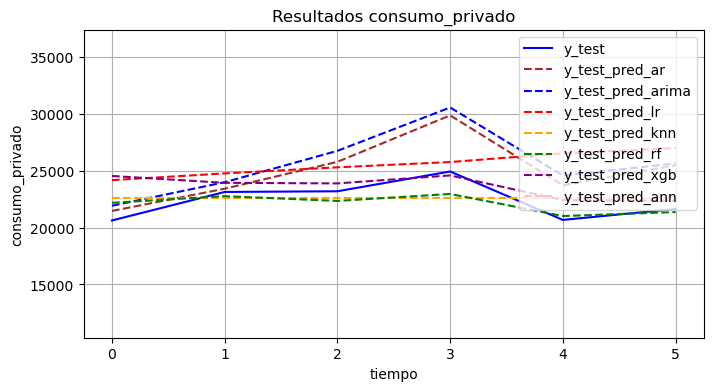

In [18]:
def plot_comparison(results, y_test, target_var):
    colors = {'ar' : 'brown',
              'arima' : 'blue',
              'lr' : 'red',
              'knn' : 'orange',
              'rf' : 'green',
              'xgb' : 'purple',
              'ann' : 'pink'}
    
    plt.figure(figsize=(8, 4))
    plt.plot(y_test.values, label="y_test", color="blue")
    
    for name, result in results.items():
        if name in ('ar', 'arima'):
            plt.plot(result['y_test_pred'].reset_index(drop=True), label=f"y_test_pred_{name}", color=colors[name], linestyle="--")
        else:
            plt.plot(result['y_test_pred'], label=f"y_test_pred_{name}", color=colors[name], linestyle="--")
    

    y_max = max(y_test.values)
    y_min = min(y_test.values)
    upper_limit = y_max * 1.5
    lower_limit = y_min * 0.5
    
    plt.ylim(lower_limit, upper_limit)
    
    plt.xlabel("tiempo")
    plt.ylabel(target_var)
    plt.title(f"Resultados {target_var}")
    plt.legend(loc='upper right')
    plt.grid()
    plt.savefig(os.path.join(output_path, 'figures', f'result_{target_var}.png'), dpi=300)
    plt.show()

plot_comparison(results, y_test, target_var)

## Best Model

* ar: train_rmse=680.98, test_rmse=2,607.58
* arima: train_rmse=27,956.80, test_rmse=48,586.01
* lr: train_rmse=2,052.21, test_rmse=2,513.11
* knn: train_rmse=2,501.46, test_rmse=3,591.38
* rf: train_rmse=1,494.13, test_rmse=4,942.72
* xgb: train_rmse=0.35, test_rmse=4,459.99
* ann: train_rmse=3,309.24, test_rmse=20,020.52

Mejor modelo: lr

Random Forest Best Parameters: {'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 42}